In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_3 = X[:,[0,2,3]]

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)
#m = np.amax(X_scaled)
#X_ball = X_scaled/m

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [38]:
np.mean(X_scaled, axis=0)
np.std(X_scaled, axis=0)

array([1., 1., 1.])

In [39]:
def homo(A,filename = 'Test',name='w1',epoch=1):
    np.set_printoptions(precision=4,threshold=10_000,suppress = True)
    if torch.is_tensor(A):
        A = A.detach().numpy()
    h = np.ones((A.shape[0],1))
    A_homo = np.concatenate((h,A), axis = 1)
    mat = np.matrix(A_homo)
    with open(filename+'/'+name+'_ep'+str(epoch)+'.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    
    return

In [40]:
# size of the first layer
l1 = 200

In [41]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        #self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(l1, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        #x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [42]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=3, out_features=200, bias=True)
  (layer3): Linear(in_features=200, out_features=3, bias=True)
)

In [43]:
# if parameters should be saved, put save = 1
save = 0

In [44]:
if save == 1:
    filename = 'Iris_5'
    os.mkdir(filename)
    os.mkdir(filename+'_vertices')

In [45]:
#initialize lists

EPOCHS  = 25

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

if save == 1:
    homo(w1_norm,filename,'w1',0)
    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
    
    
    
    w1 = model.layer1.weight
    b1 = model.layer1.bias
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    if save == 1:
        homo(w1_norm,filename,'w1',k)
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    k = k+1
    
if save == 1:
    with open(filename+'/network_params.npy', 'wb') as f:
        np.save(f, weights)
        np.save(f, weights_norm)
        np.save(f, norms)
        np.save(f, biases)

accuracy_list

100%|██████████| 25/25 [00:00<00:00, 659.66it/s]


array([0.93333334, 0.83333331, 0.80000001, 0.83333331, 0.83333331,
       0.83333331, 0.89999998, 0.93333334, 0.93333334, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664])

In [46]:
#mcbe
est_alpha, subframes, est_points =mcbe.mcbe(polytope=np.array(weights)[-1],N=X_train.shape[0],distribution="ball",radius = np.max(np.array(X_train)), give_subframes=True,sample_on_sphere=False)

C:\Users\heckert\AppData\Local\Temp\ipykernel_1280\946488397.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(est_points[:,0],est_points[:,1], est_points[:,2], cmap='Set2', s=100)


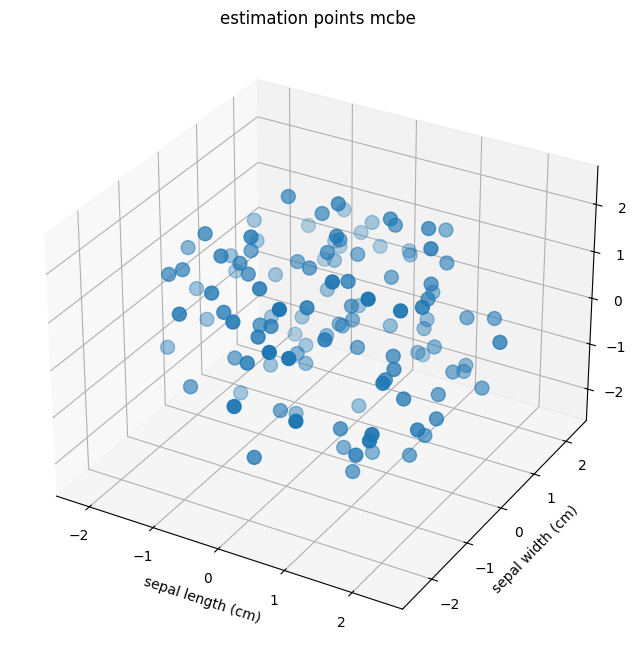

In [47]:
# plot data in 3d to see distribution of the data
est_points = np.array(est_points)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(est_points[:,0],est_points[:,1], est_points[:,2], cmap='Set2', s=100)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
plt.title("estimation points mcbe")
plt.show()

C:\Users\heckert\AppData\Local\Temp\ipykernel_1280\4252826463.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_scaled[:,0], X_scaled[:,1], X_scaled[:,2], cmap='Set2', s=100)


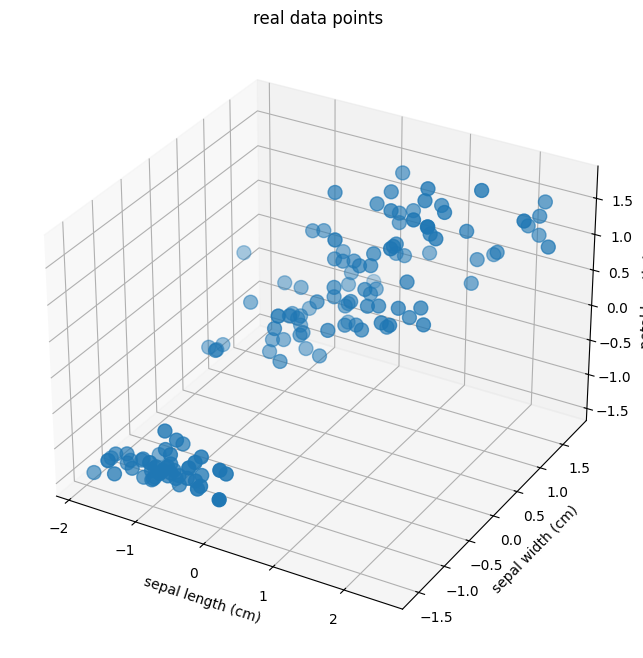

In [48]:
# plot data in 3d to see distribution of the data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:,0], X_scaled[:,1], X_scaled[:,2], cmap='Set2', s=100)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
plt.title("real data points")
plt.show()

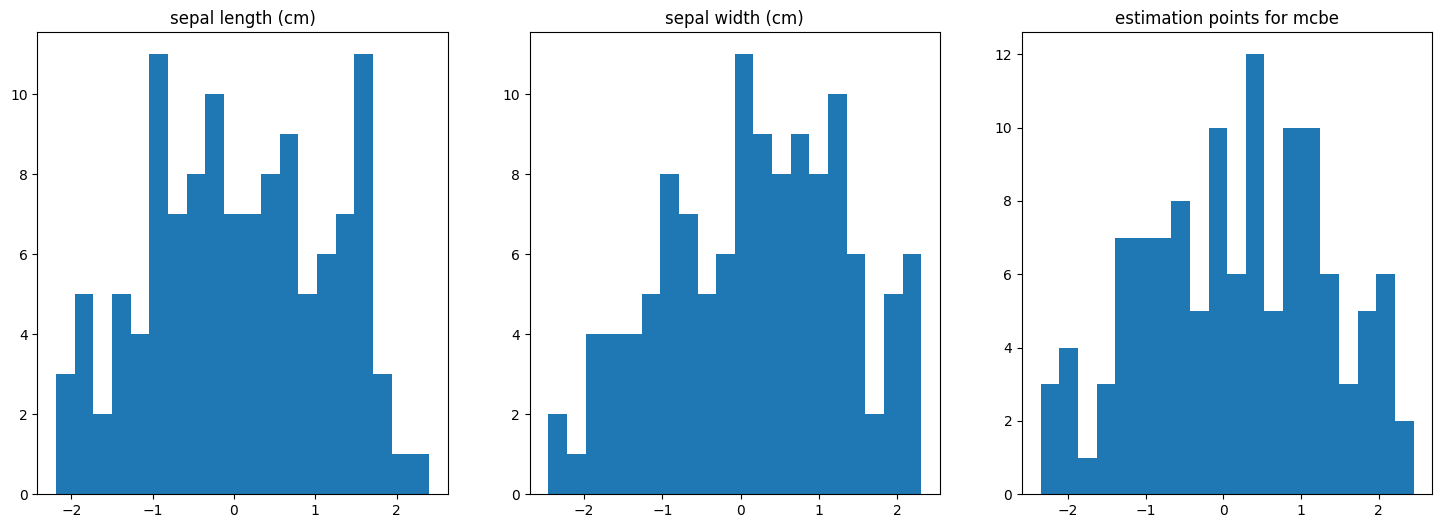

In [49]:
#plot histogram of each feature to see distribution of the variables
fig = plt.figure(figsize=(18, 6))

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(est_points[:,i], bins=20)
    ax.set_title(feature_names[i])

plt.title("estimation points for mcbe")
plt.show()

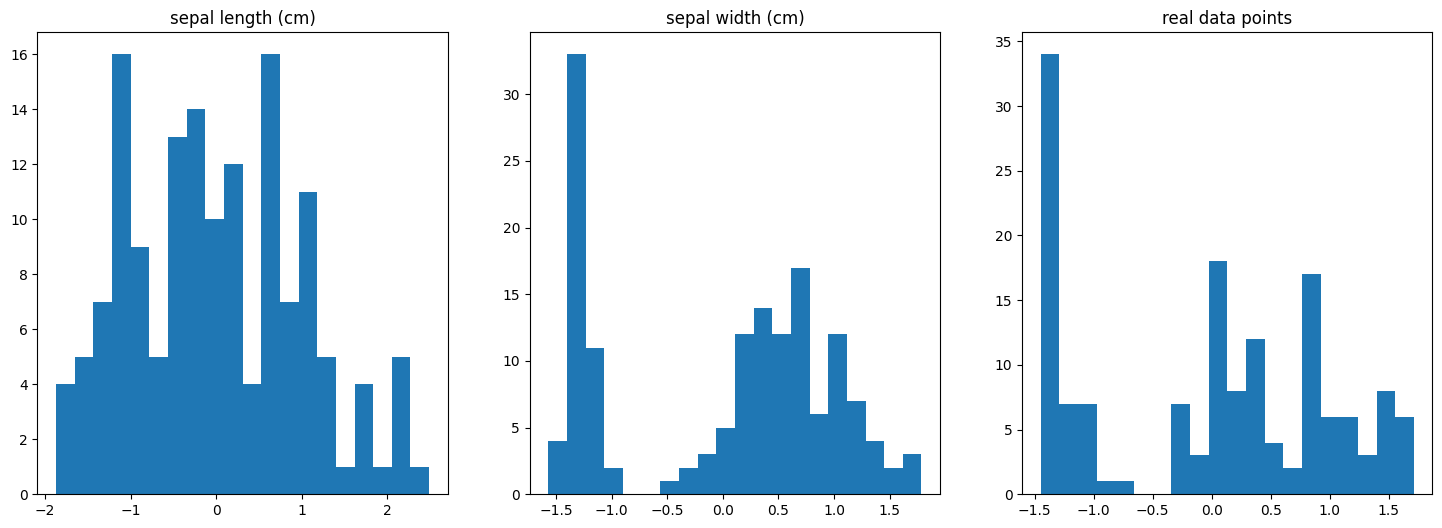

In [50]:
#plot histogram of each feature to see distribution of the variables
fig = plt.figure(figsize=(18, 6))

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(X_scaled[:,i], bins=20)
    ax.set_title(feature_names[i])

plt.title("real data points")
plt.show()

In [51]:
np.mean(est_alpha - biases[-1] >= 0)

0.995

## use trainingsdata for bias estimation

In [52]:
est_alpha_td, subframes_td, est_points_td = mcbe.be_given_points(polytope=np.array(weights)[-1],points=X_train, give_subframes=True)

In [53]:
np.mean(est_alpha_td - biases[-1] >= 0)

0.99

I compare the bias estimated with the training data with the mcbe on the ball by doing the "naive testing":

In [54]:
percent_inj_td = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_td, points=X_test,iter=X_test.shape[0])
print("percent injective for bias estimated by the train data:",percent_inj_td)

percent injective for bias estimated by the train data: 0.9666666666666667


In [55]:
percent_inj = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha, points=X_test,iter=X_test.shape[0])
print("percent injective for bias estimated by mcbe with same number of sampling points like in the train data:",percent_inj)


percent injective for bias estimated by mcbe with same number of sampling points like in the train data: 0.8


## use permutation of the trainings data to create more samples

In [56]:
# create more datapoints by adding noise to the original data
times_to_blowup = 3
X_train_noisy = X_train + np.random.normal(0,0.5,X_train.shape)
for i in range(times_to_blowup-1):
    X_train_noisy = torch.cat((X_train_noisy,X_train + np.random.normal(0,0.5,X_train.shape)),0)
    
# rowbind the original data and the noisy data by adding the noisy data to the original data
X_train_blowup = torch.cat((X_train,X_train_noisy),0)


In [57]:
# create more datapoints by sampling 

X_train_rd = np.random.normal(0,1,X_train.shape)
X_train_rd = torch.from_numpy(X_train_rd).float()
for i in range(times_to_blowup-1):
    X_train_rd = torch.cat((X_train_rd, torch.from_numpy(np.random.normal(0,1,X_train.shape))),0)
    
# rowbind the original data and the noisy data by adding the noisy data to the original data
X_train_add_rd = torch.cat((X_train,X_train_rd),0)


C:\Users\heckert\AppData\Local\Temp\ipykernel_1280\2638452117.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_noisy[:,0], X_train_noisy[:,1], X_train_noisy[:,2], cmap='Set2', s=50, label = "noisy data",zorder=1,alpha=0.3)
C:\Users\heckert\AppData\Local\Temp\ipykernel_1280\2638452117.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], cmap='Set2', s=50, label = "original data",zorder=2,alpha=1)


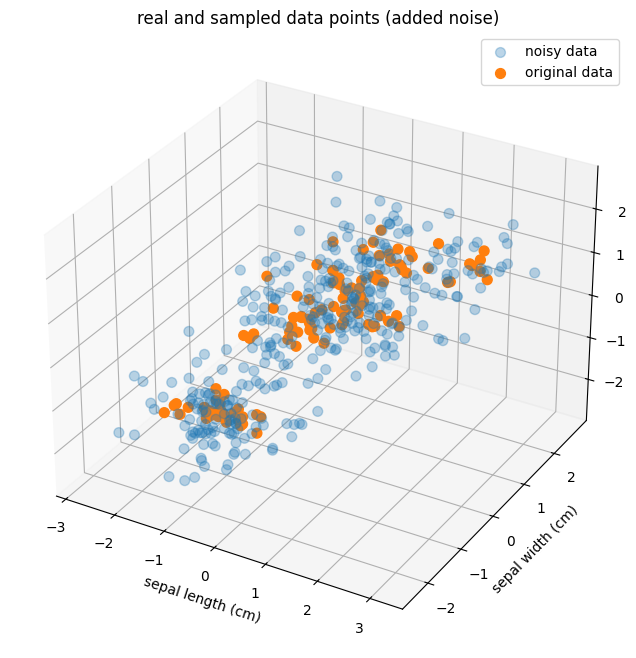

In [58]:
# plot data in 3d to see distribution of the data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_noisy[:,0], X_train_noisy[:,1], X_train_noisy[:,2], cmap='Set2', s=50, label = "noisy data",zorder=1,alpha=0.3)
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], cmap='Set2', s=50, label = "original data",zorder=2,alpha=1)
ax.legend()
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
plt.title("real and sampled data points (added noise)")
plt.show()

C:\Users\heckert\AppData\Local\Temp\ipykernel_1280\92355173.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_rd[:,0], X_train_rd[:,1], X_train_rd[:,2], cmap='Set2', s=50, label = "random data",zorder=1,alpha=0.3)
C:\Users\heckert\AppData\Local\Temp\ipykernel_1280\92355173.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], cmap='Set2', s=50, label = "original data",zorder=2,alpha=1)


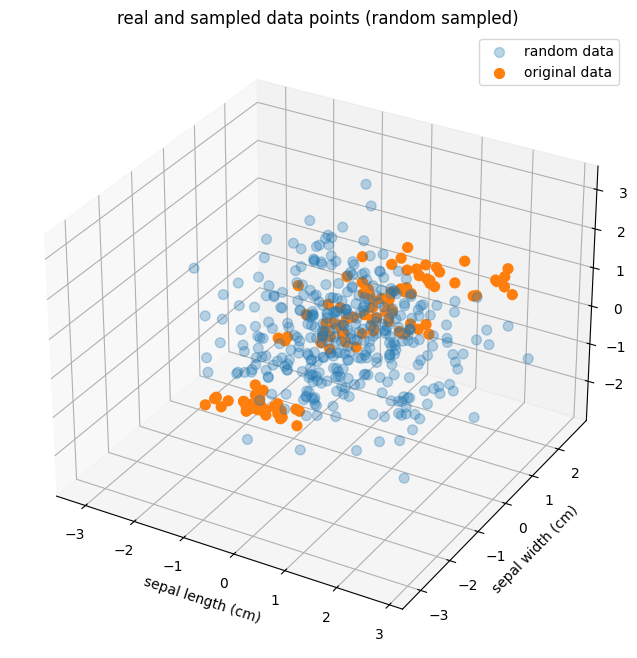

In [59]:
# plot data in 3d to see distribution of the data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_rd[:,0], X_train_rd[:,1], X_train_rd[:,2], cmap='Set2', s=50, label = "random data",zorder=1,alpha=0.3)
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], cmap='Set2', s=50, label = "original data",zorder=2,alpha=1)
ax.legend()
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
plt.title("real and sampled data points (random sampled)")
plt.show()

Using the generated data for mcbe:

In [60]:
est_alpha_blowup, subframes_blowup, est_points_blowup = mcbe.be_given_points(polytope=np.array(weights)[-1],points=X_train_blowup, give_subframes=True)

In [61]:
est_alpha_rd, subframes_rd, est_points_rd = mcbe.be_given_points(polytope=np.array(weights)[-1],points=X_train_add_rd, give_subframes=True)

In [62]:
np.mean(est_alpha_blowup - biases[-1] >= 0)

0.985

In [63]:
np.mean(est_alpha_rd - biases[-1] >= 0)

0.97

I compare the bias estimated with the blown up training data with the mcbe on the ball by doing the "naive testing":

In [64]:
percent_inj_blowup = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_blowup, points=X_test,iter=X_test.shape[0])
print("percent injective for bias estimated by the blown up train data:",percent_inj_blowup)

percent injective for bias estimated by the blown up train data: 0.9666666666666667


In [65]:
percent_inj_rd = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_rd, points=X_test,iter=X_test.shape[0])
print("percent injective for bias estimated by the random added train data:",percent_inj_rd)

percent injective for bias estimated by the random added train data: 0.9666666666666667


In [66]:
#mcbe for comparison
est_alpha, subframes, est_points =mcbe.mcbe(polytope=np.array(weights)[-1],N=X_train_blowup.shape[0],distribution="ball",radius=np.max(np.array(X_train)), give_subframes=True,sample_on_sphere=False)

In [67]:
percent_inj = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha, points=X_test,iter=X_test.shape[0])
print("percent injective for bias estimated by mcbe with same number of sampling points like in the train data:",percent_inj)

percent injective for bias estimated by mcbe with same number of sampling points like in the train data: 0.8
